In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms.v2 as v2
from torchmetrics.functional import pairwise_cosine_similarity

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import sys

sys.path.append('./src')
from src.data import MultiSet, multi_collate, ImageTransforms, SignalTransforms
from src.models import TSBERT, CLIP

from accelerate import Accelerator
from accelerate.utils import GradientAccumulationPlugin

import scienceplots

plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

In [2]:
data_path = Path('./data/CytoSense')
annotation_file = 'train_10.csv'

image_transforms = ImageTransforms()
signal_transforms = SignalTransforms(max_len=512)

dataset = MultiSet(data_path=data_path, annotation_file=annotation_file, 
                   image_transforms=image_transforms, image_size=(256, 256),
                   signal_transforms=signal_transforms)

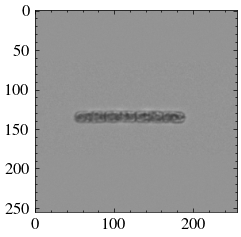

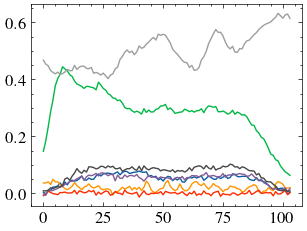

681

In [10]:
ix = 0

image, signal, y = dataset[ix]

plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.plot(signal)
plt.show()
dataset.X[ix]

## Cross-Modality Training

In [11]:
collate_bert = lambda batch: multi_collate(batch, bert=True)
dataloader = DataLoader(dataset=dataset, batch_size=20, 
                        shuffle=True, num_workers=8, 
                        drop_last=True, collate_fn=collate_bert)
print(f'{len(dataloader) = }')

signal_encoder = TS_BERT(dim_emb=128, dim_feedforward=512)

image_encoder = torchvision.models.resnet18()
image_encoder.fc = nn.Linear(512, 128)

clip = CLIP(image_encoder, signal_encoder)

optimizer = optim.Adam(clip.parameters(), lr=1e-4, weight_decay=1e-9)

plugin = GradientAccumulationPlugin(num_steps=10, sync_with_dataloader=False)
accelerator = Accelerator(mixed_precision='fp16', gradient_accumulation_plugin=plugin)
clip, optimizer, dataloader = accelerator.prepare(clip, optimizer, dataloader)

losses = []

len(dataloader) = 50


NameError: name 'TS_BERT' is not defined

In [12]:
_, sig, _ = next(iter(dataloader))

In [13]:
sig

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.0734e-02,  3.3413e-02,  4.9847e-02,  ...,  1.8241e-02,
           3.3072e-03,  5.1127e-01],
         [ 2.5275e-02,  3.8730e-02,  4.3748e-02,  ...,  1.4235e-02,
           3.7115e-03,  4.9528e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.0536e-03,  6.9271e-03,  8.0903e-03,  ..., -5.2264e-03,
           2.5579e-03,  3.3958e-01],
         [ 8.6506e-03,  1.5116e-02,  2.0506e-02,  ...,  6.0741e-03,
           4.0334e-03,  3.8171e-01],
         ...,
         [ 0.0000e+00,  0

In [7]:
sum(p.numel() for p in clip.model_1.parameters()), \
    sum(p.numel() for p in clip.model_2.parameters())


(11242176, 794112)

In [8]:
epochs = 5
steps = len(dataloader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(dataloader)

accum_steps = accelerator.gradient_accumulation_steps
accumulated_loss = 0

clip.train()

for i in iterator:

    try:
        image, signal, y = next(generator)
    except StopIteration:
        generator = iter(dataloader)
        image, signal, y = next(generator)

    with accelerator.accumulate(clip):
        optimizer.zero_grad()
        _, _, loss = clip(image, signal)
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        accumulated_loss /= accum_steps
        losses.append(accumulated_loss)
        iterator.set_description(f'{accumulated_loss = :.5f}')
        accumulated_loss = 0


accumulated_loss = 2.63498: 100%|██████████| 250/250 [29:09<00:00,  7.00s/it]


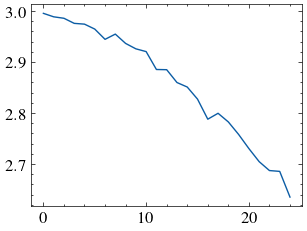

In [9]:
plt.plot(losses)

In [10]:
clip.logit_scale

Parameter containing:
tensor(1.0023, requires_grad=True)

In [12]:
test_set = MultiSet(data_path, 'test_10')
test_set.label_encoder = dataset.label_encoder
test_loader = DataLoader(test_set, 20, collate_fn=collate_bert)
test_loader = accelerator.prepare(test_loader)

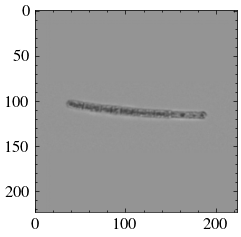

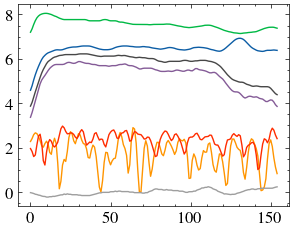

(1839, 155)

In [13]:
ix = 979

image, signal, y = test_set[ix]

plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.plot(signal)
plt.show()
test_set.X[ix], len(signal)

In [14]:
clip.eval()

I_e = []
S_e = []
label = []
test_losses = []

for image, signal, y in tqdm(test_loader):
    with torch.no_grad():
        encoding_1, encoding_2, loss = clip(image, signal)
        I_e.append(encoding_1.cpu())
        S_e.append(encoding_2.cpu())
        label.append(y.cpu())
        test_losses.append(loss.detach().item())

I_e = torch.cat(I_e)
S_e = torch.cat(S_e)
label = torch.cat(label)

print(f'Loss = {np.mean(test_losses)}')

  0%|          | 0/231 [00:00<?, ?it/s]

100%|██████████| 231/231 [03:45<00:00,  1.02it/s]

Loss = 2.976094459558462


In [15]:
I_e_np = I_e.numpy()
S_e_np = S_e.numpy()
label_np = label.numpy()

from sklearn.manifold import TSNE

E = TSNE(2, perplexity=10, early_exaggeration=20).fit_transform((I_e_np + S_e_np) / 2)

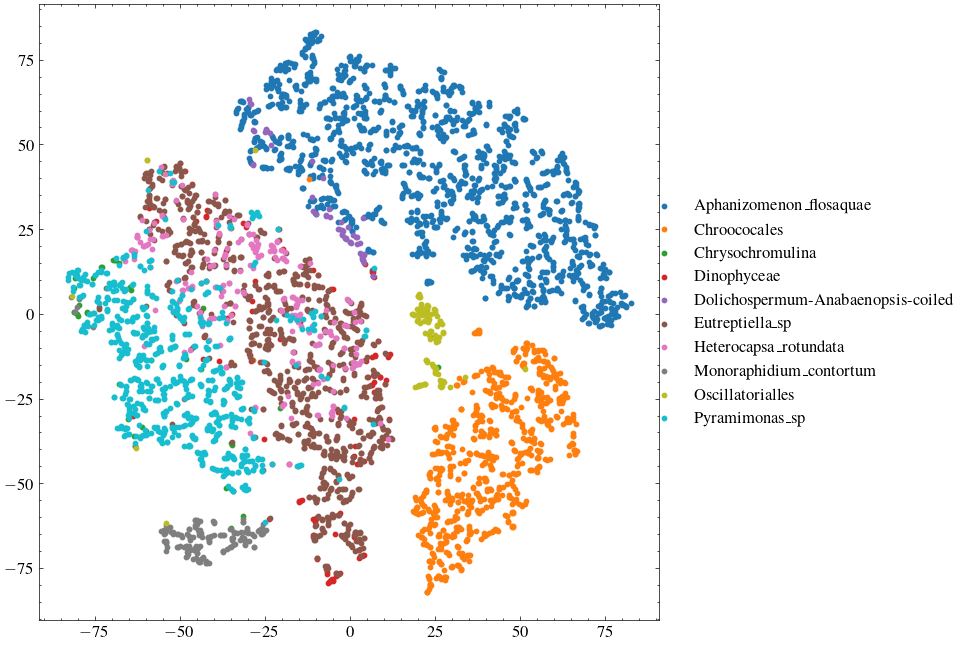

In [16]:
fig, ax = plt.subplots()

for y, c in zip(np.unique(label_np), mcolor.TABLEAU_COLORS.values()):
    class_name = test_set.label_encoder.inverse_transform([y])[0]
    e = E[label == y]
    ax.scatter(*zip(*e), label=class_name, s=10, c=c)


fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

## Training the classifier

In [21]:
classifier = nn.Sequential(
    nn.Linear(128, 1024),
    nn.GELU(),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Linear(1024, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-9)
classifier, optimizer = accelerator.prepare(classifier, optimizer)

losses = []

In [22]:
epochs = 5
steps = len(dataloader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(dataloader)

clip.eval()
classifier.train()
accumulated_loss = 0
accum_steps = accelerator.gradient_accumulation_steps
accum_steps
for _ in iterator:

    try:
        image, signal, y = next(generator)
    except StopIteration:
        generator = iter(dataloader)
        image, signal, y = next(generator)

    with torch.no_grad():
        encoding_1, encoding_2, _ = clip(image, signal)

    x = (encoding_1 + encoding_2) / 2

    with accelerator.accumulate(classifier):
        optimizer.zero_grad()
        out = classifier(x)
        loss = criterion(out, y)
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        losses.append(accumulated_loss)
        iterator.set_description(f'{accumulated_loss = :.5f}')
        accumulated_loss = 0


accumulated_loss = 2.06082: 100%|██████████| 250/250 [09:06<00:00,  2.19s/it]


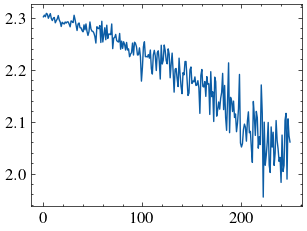

In [23]:
plt.plot(losses)

In [24]:
x = (I_e + S_e).div(2).to(accelerator.device)

with torch.no_grad():
    pred = classifier(x).cpu().argmax(1)

pred


tensor([0, 0, 0,  ..., 7, 7, 7])

In [26]:
from sklearn.metrics import classification_report

names = test_set.label_encoder.inverse_transform(list(range(10)))
pd.DataFrame(classification_report(label, pred, target_names=names, output_dict=True)).T

/home/veikka/miniconda3/envs/dippa/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/veikka/miniconda3/envs/dippa/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/veikka/miniconda3/envs/dippa/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

,precision,recall,f1-score,support
Aphanizomenon_flosaquae,0.959577,0.989737,0.974424,1559.000000
Chroococales,0.958501,0.975477,0.966914,734.000000
Chrysochromulina,0.000000,0.000000,0.000000,46.000000
Dinophyceae,0.086957,0.033613,0.048485,119.000000
Dolichospermum-Anabaenopsis-coiled,0.178295,0.410714,0.248649,56.000000
Eutreptiella_sp,1.000000,0.002183,0.004357,916.000000
Heterocapsa_rotundata,0.466667,0.030568,0.057377,229.000000
Monoraphidium_contortum,0.074344,1.000000,0.138399,153.000000
Oscillatorialles,0.500000,0.009709,0.019048,103.000000
Pyramimonas_sp,0.000000,0.000000,0.000000,692.000000


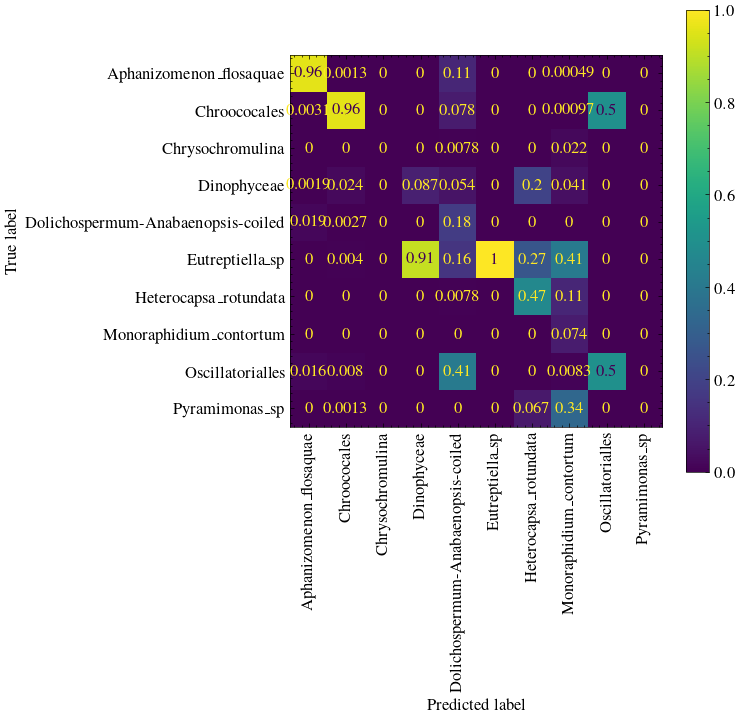

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()
cm = confusion_matrix(label, pred, normalize='pred')
ConfusionMatrixDisplay(cm, display_labels=names).plot(xticks_rotation='vertical', ax=ax)
fig.set_size_inches(6, 6)

